In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2

In [3]:
DATA_DIR = "../data/"

## 1. Taxon to media sources

### KOMODO

* **komodo_taxa.txt**: downloaded from [KOMODO](https://komodo.modelseed.org/servlet/KomodoTomcatServerSideUtilitiesModelSeed?OrganismMedia)

* **komodo_media.txt**: downloaded from [KOMODO](https://komodo.modelseed.org/servlet/KomodoTomcatServerSideUtilitiesModelSeed?MediaList)

In [4]:
komodo_taxa = pd.read_table(
    os.path.join(
        DATA_DIR,
        "komodo",
        "komodo_taxa.txt"
    )
)

komodo_taxa["taxon_id"] = komodo_taxa["taxon_id"]\
    .astype(str)\
    .replace(r".0$", "", regex=True)

komodo_taxa

,dsmz_id,taxon_id,organism_name,media_name
0,6268,nan,NaN,Substrate for DSM 6268
1,9849,46125,Abiotrophia defectiva,PYG-MEDIUM (modified)
2,14247,291968,Acaricomes phytoseiuli,TRYPTICASE SOY Yeast extract medium
3,23669,nan,Acetatifactor muris,For DSM 23669
4,5522,2382,Acetitomaculum ruminis,ACETITOMACULUM medium | METHANOBACTERIUM medium
...,...,...,...,...
8623,473,120045,Zymomonas mobilis subsp. mobilis,ZYMOMONAS medium
8624,22645,120044,Zymomonas mobilis subsp. pomaceae,ZYMOMONAS medium
8625,7201,86958,Zymophilus paucivorans,MEDIUM 58 MODIFIED FOR DSM 7201
8626,20765,86959,Zymophilus raffinosivorans,MEDIUM 58 MODIFIED FOR DSM 20765


In [5]:
komodo_media = pd.read_table(
    os.path.join(
        DATA_DIR,
        "komodo",
        "komodo_media.txt"
    )
)
komodo_media

,media_id,media_name,ph,complex,aerobic,submedium,instructions
0,1,NUTRIENT AGAR,7.0,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
1,10,ZYMOMONAS medium,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
2,1000,MJANHOX-NO3 MEDIUM WITH SUPPLEMENT,7.5 - 8.0,False,True,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3,1001,BASAL MEDIUM,6.8 - 7,False,True,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
4,1002,ECTOTHIORHODOSYNUS medium,9 - 9.5,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
...,...,...,...,...,...,...,...
3632,9_53191,MEDIUM 9 MODIFIED FOR DSM 53191,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3633,9_53271,MEDIUM 9 MODIFIED FOR DSM 53271,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3634,9_53343,MEDIUM 9 MODIFIED FOR DSM 53343,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3635,9_53796,MEDIUM 9 MODIFIED FOR DSM 53796,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...


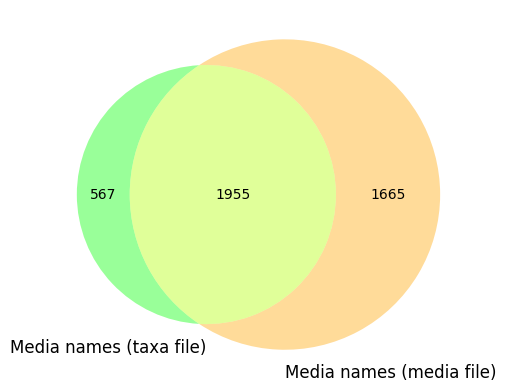

In [6]:
venn2(
    subsets=[
        set(komodo_taxa["media_name"]),
        set(komodo_media["media_name"])
    ],
    set_labels=[
        "Media names (taxa file)",
        "Media names (media file)"
    ],
    set_colors=[
        "lime",
        "orange"
    ]
)

In [7]:
komodo_df = pd.merge(
    left=komodo_taxa,
    right=komodo_media,
    on="media_name",
    how="outer",
    indicator=True
)

# Add extra column indicating the source of the data
komodo_df = komodo_df.rename(columns={"_merge": "source"})
komodo_df["source"] = komodo_df["source"]\
    .cat.rename_categories({
        "right_only": "komodo_taxa.txt",
        "left_only": "komodo_media.txt"
    })

komodo_df.to_csv(
    os.path.join(
        DATA_DIR,
        "processed",
        "komodo.csv"
    ),
    sep=";",
    index=False
)

komodo_df

,dsmz_id,taxon_id,organism_name,media_name,media_id,ph,complex,aerobic,submedium,instructions,source
0,NaN,NaN,NaN,1/10 NUTRIENT AGAR NO.2,952,7.0 - 7.2,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,komodo_taxa.txt
1,21034,nan,Rhizomicrobium electricum,1/10 PYGV medium modified,1398,7.0,True,True,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,both
2,NaN,NaN,NaN,1/100 NUTRIENT AGAR NO.2,953,7.0 - 7.2,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,komodo_taxa.txt
3,12412,44255,Agromonas oligotrophica,1/100 NUTRIENT AGAR NO.2 | 1/10 NUTRIENT AGAR ...,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
4,22777,nan,Sphaerochaeta globosa,1/2 TRYPTIC SOY BROTH (ANAEROBE),1205,"7.2, HCl",True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,both
...,...,...,...,...,...,...,...,...,...,...,...
10317,18958,56450,Xanthomonas cassavae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
10318,18797,56464,Xanthomonas theicola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
10319,14987,263819,Yersinia aleksiciae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
10320,25701,nan,Zhongshania antarctica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt


### MediaDive

In [8]:
import modules.mediadive as md

In [9]:
id_list = [
    "65",
    "514",
    "830",
    "92",
    "1",
    "535",
    "220",
    "11",
    "693",
    "104",
    "53",
    "645",
    "110",
    "585",
    "58",
    "429",
    "372",
    "545",
    "98",
    "9",
    "63",
    "553",
    "78",
    "84",
    "104b",
    "215",
    "381",
    "425",
    "119",
    "535b",
    "554",
    "736",
    "67",
    "804",
    "27",
    "83",
    "641.1",
    "354",
    "123",
    "621",
    "760.1",
    "339.1",
    "339",
    "595",
    "31",
    "144",
    "330",
    "214",
    "593",
    "371"
]

In [10]:
md_comp_df = md.get_composition(id_list)
md_comp_df

Retrieved data for 65
Retrieved data for 514
Retrieved data for 830
Retrieved data for 92
Retrieved data for 1
Retrieved data for 535
Retrieved data for 220
Retrieved data for 11
Retrieved data for 693
Retrieved data for 104
Retrieved data for 53
Retrieved data for 645
Retrieved data for 110
Retrieved data for 585
Retrieved data for 58
Retrieved data for 429
Retrieved data for 372
Retrieved data for 545
Retrieved data for 98
Retrieved data for 9
Retrieved data for 63
Retrieved data for 553
Retrieved data for 78
Retrieved data for 84
Retrieved data for 104b
Retrieved data for 215
Retrieved data for 381
Retrieved data for 425
Retrieved data for 119
Retrieved data for 535b
Retrieved data for 554
Retrieved data for 736
Retrieved data for 67
Retrieved data for 804
Retrieved data for 27
Retrieved data for 83
Request failed with status code: 404
Retrieved data for 641.1
Retrieved data for 354
Retrieved data for 123
Retrieved data for 621
Request failed with status code: 404
Retrieved data for

,media_id,components,component_ids
0,65,"[Glucose, Yeast extract, Malt extract, CaCO3, ...","[5, 16, 116, 13, 3, 4]"
1,514,"[Bacto peptone, Yeast extract, Fe(III) citrate...","[19, 16, 45, 43, 453, 110, 81, 61, 55, 174, 52..."
2,830,"[Yeast extract, Proteose peptone, Casamino aci...","[16, 208, 101, 5, 199, 113, 10, 8, 3, 4]"
3,92,"[Trypticase soy broth, Yeast extract, Agar, Di...","[99, 16, 3, 4]"
4,1,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]"
5,535,"[Trypticase soy broth, Agar, Distilled water]","[99, 3, 4]"
6,220,"[Casein peptone, Soy peptone, NaCl, Agar, Dist...","[21, 75, 43, 3, 4]"
7,11,"[Casein peptone, Meat extract, Yeast extract, ...","[21, 2, 16, 5, 22, 10, 23, 24, 8, 14, 4]"
8,693,"[Columbia agar base, Defibrinated sheep blood,...","[2110, 1717, 21, 75, 94, 43, 10, 4, 186, 4, 1,..."
9,104,"[Trypticase peptone, Peptone, Yeast extract, B...","[124, 1, 16, 85, 5, 10, 22, 174, 25, 125, 124,..."


In [11]:
md_strains_df = md.get_strains(id_list)
md_strains_df

Retrieved data for 65
Retrieved data for 514
Retrieved data for 830
Retrieved data for 92
Retrieved data for 1
Retrieved data for 535
Retrieved data for 220
Retrieved data for 11
Retrieved data for 693
Retrieved data for 104
Retrieved data for 53
Retrieved data for 645
Retrieved data for 110
Retrieved data for 585
Retrieved data for 58
Retrieved data for 429
Retrieved data for 372
Retrieved data for 545
Retrieved data for 98
Retrieved data for 9
Retrieved data for 63
Retrieved data for 553
Retrieved data for 78
Retrieved data for 84
Retrieved data for 104b
Retrieved data for 215
Retrieved data for 381
Retrieved data for 425
Retrieved data for 119
Retrieved data for 535b
Retrieved data for 554
Retrieved data for 736
Retrieved data for 67
Retrieved data for 804
Retrieved data for 27
Retrieved data for 83
Request failed with status code: 404
Retrieved data for 641.1
Retrieved data for 354
Retrieved data for 123
Retrieved data for 621
Request failed with status code: 404
Retrieved data for

,media_id,strain_id,species,ccno,bacdive_id
0,65,233,Rhodococcus sp.,DSM 364,10957.0
1,65,359,Pseudonocardia autotrophica,DSM 535,13324.0
2,65,488,Streptomyces tanashiensis,DSM 731,16033.0
3,65,495,Streptomyces clavuligerus,DSM 738,15101.0
4,65,500,Rhodococcus erythropolis,DSM 743,10853.0
...,...,...,...,...,...
28942,371,14347,Natronococcus roseus,DSM 25473,24068.0
28943,371,16447,Natrialba chahannaoensis,DSM 29986,130845.0
28944,371,16448,Natrialba hulunbeirensis,DSM 29987,130844.0
28945,371,29106,Salicibibacter cibarius,DSM 111417,160200.0


In [12]:
md_df = pd.merge(
    left=md_comp_df,
    right=md_strains_df,
    on="media_id",
    how="outer",
    indicator=True
)

# Add extra column indicating the source of the data
md_df = md_df.rename(columns={"_merge": "source"})
md_df["source"] = md_df["source"]\
    .cat.rename_categories({
        "right_only": "composition_only",
        "left_only": "strains_only"
    })

md_df.to_csv(
    os.path.join(
        DATA_DIR,
        "processed",
        "mediadive.csv"
    ),
    sep=";",
    index=False
)

md_df

,media_id,components,component_ids,strain_id,species,ccno,bacdive_id,source
0,1,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",1,Heyndrickxia coagulans,DSM 1,654.0,both
1,1,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",2,Paenibacillus macquariensis subsp. macquariensis,DSM 2,11477.0,both
2,1,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",3,Sporosarcina psychrophila,DSM 3,11984.0,both
3,1,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",6,Peribacillus psychrosaccharolyticus,DSM 6,748.0,both
4,1,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",7,Bacillus amyloliquefaciens,DSM 7,598.0,both
...,...,...,...,...,...,...,...,...
28942,98,"[Yeast extract, Mannitol, Agar, Soil extract, ...","[16, 6, 3, 5555, 4, 2083, 32, 4]",27539,Rhizobium tarimense,DSM 105042,132917.0,both
28943,98,"[Yeast extract, Mannitol, Agar, Soil extract, ...","[16, 6, 3, 5555, 4, 2083, 32, 4]",14139,Rhizobium selenitireducens,DSM 25108,160666.0,both
28944,98,"[Yeast extract, Mannitol, Agar, Soil extract, ...","[16, 6, 3, 5555, 4, 2083, 32, 4]",26155,Rhizobium sp.,DSM 102088,160164.0,both
28945,98,"[Yeast extract, Mannitol, Agar, Soil extract, ...","[16, 6, 3, 5555, 4, 2083, 32, 4]",57396,Mesorhizobium sp.,DSM 113538,NaN,both


### Final table: taxon to media

## 2. EC number sources

### UniProt

### KEGG

### Final table: taxon to EC

### Final table: media to EC